# Pose Estimation

**What is pose estimation**
Pose estimation predicts different poses based on a person’s body parts and joint positioning in an image or video. We can automatically detect the joints, arms, hips, and spine position while performing a squat.

Use cases:
- Athlete rehabilitating after an injury or undergoing strength training; the pose estimation may help sports analysts analyze vital points from the starting position to the end position of a squat

## Pose Similairty Metric

Given two 3d pose's - calculate whether the poses are the same.

https://medium.com/@cavaldovinos/human-pose-estimation-pose-similarity-dc8bf9f78556

### MediaPipe Github: https://github.com/google/mediapipe


Follow along from the video to get up and running:

https://www.youtube.com/watch?v=SSW9LzOJSus

In [1]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import os
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from dtaidistance import dtw
from os import listdir
from os.path import isfile, join
import itertools

In [3]:
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic

POSE_LANDMARKS = [m.name for m in mp_pose.PoseLandmark]

In [4]:
def calc_angle_in_3d_space(a, b, c):  
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    
    v1 = np.array([ a[0] - b[0], a[1] - b[1], a[2] - b[2] ])
    v2 = np.array([ c[0] - b[0], c[1] - b[1], c[2] - b[2] ])

    v1mag = np.sqrt([ v1[0] * v1[0] + v1[1] * v1[1] + v1[2] * v1[2] ])
    v1norm = np.array([ v1[0] / v1mag, v1[1] / v1mag, v1[2] / v1mag ])

    v2mag = np.sqrt(v2[0] * v2[0] + v2[1] * v2[1] + v2[2] * v2[2])
    v2norm = np.array([ v2[0] / v2mag, v2[1] / v2mag, v2[2] / v2mag ])
    res = v1norm[0] * v2norm[0] + v1norm[1] * v2norm[1] + v1norm[2] * v2norm[2]
    angle_rad = np.arccos(res)
    
    if angle_rad > np.pi:
        angle_rad = 2*np.pi - angle_rad

    return math.degrees(angle_rad)


def calc_angle_in_2d_space(a, b, c):  
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    radians = np.abs(radians)
    
    if radians > np.pi:
        angle_rad = 2*np.pi - angle_rad

    return np.degrees(radians)


def get_coords_from_landmark(landmark):
    return (landmark.x, landmark.y)


## Initilize webcame

In [5]:
video = cv2.VideoCapture(0)

webcam_width  = 640
webcame_height = 480

print(f"Video width: {webcam_width} and height: {webcame_height}")

Video width: 640 and height: 480


### mp_pose.Pose Solution

In [6]:

# with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose_estimator:
#     while video.isOpened():

#         # Capture the video frame by frame
#         ret, frame = video.read()
        

        
        
#         # Detect stuff and render to output frame
#         # CV automatically parsed images in BGR format however we need it in RGB format
#         img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         # Added for performance gains
#         img_rgb.flags.writeable = False
        
#         # Estimate Pose
#         results = pose_estimator.process(img_rgb)
                
#         # Recolor back to BGR
#         img_rgb.flags.writeable = True
#         image = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        
#         # Extract Landmarks
#         try:
#             landmarks = results.pose_landmarks.landmark
            
#             # Get Coordinates
#             left_shoulder = get_coords_from_landmark(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER])
#             left_elbow = get_coords_from_landmark(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW])
#             left_wrist = get_coords_from_landmark(landmarks[mp_pose.PoseLandmark.LEFT_WRIST])
            
#             # Calc angles
#             angle_degrees = calc_angle_in_2d_space(left_shoulder, left_elbow, left_wrist)
            
#             # visualise angle
#             # calc normalised position on webcame
#             position = tuple(np.multiply(left_elbow, [webcam_width, webcame_height]).astype(int))
            
#             cv2.putText(
#                 image, 
#                 f"{angle_degrees:.3f}",
#                 position,
#                 fontFace=cv2.FONT_HERSHEY_SIMPLEX,
#                 fontScale=0.5,
#                 color=(255, 255, 255), 
#                 thickness=2,
#                 lineType=cv2.LINE_AA
#             )
            
#         except:
#             pass

        
#         # Render detections
#         mp_drawing.draw_landmarks(
#             image=image,
#             landmark_list=results.pose_landmarks, 
#             connections=mp_pose.POSE_CONNECTIONS,
#             landmark_drawing_spec = mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=2),
#             connection_drawing_spec = mp_drawing.DrawingSpec(color=(80, 200, 120), thickness=3, circle_radius=2),
#         )
        
#         # Display on image feed
#         cv2.imshow('Pose Estimation Feed', image)



#         # Press 'q' to close the videp
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

        
#     # After the loop release the cap object
#     video.release()
#     # Destroy all the windows
#     cv2.destroyAllWindows()


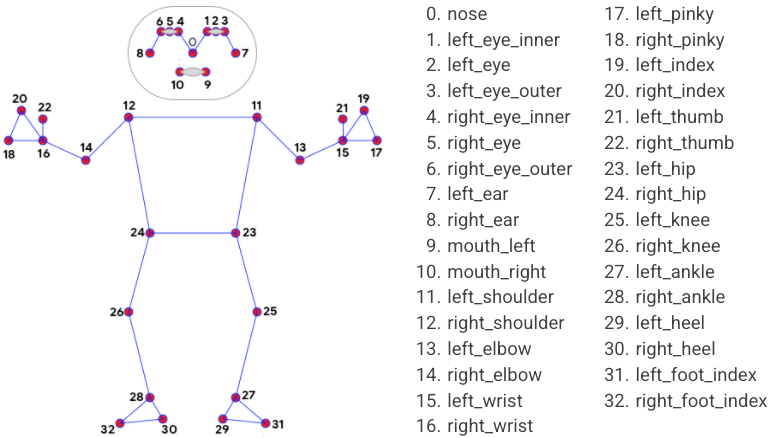

### mp_holistic solution

In [7]:

# with mp_holistic.Holistic(
#     static_image_mode=False,
#     model_complexity=1, # [0, 1, 2] - increases accuracy and latency
#     smooth_landmarks=True,
#     enable_segmentation=False,
#     smooth_segmentation=False,
#     refine_face_landmarks=False,
#     min_detection_confidence=0.5,
#     min_tracking_confidence=0.5
# ) as holistic_pose:

#     while video.isOpened():

#         # Capture the video frame by frame
#         ret, frame = video.read()

        
#         # Detect stuff and render to output frame
#         # CV automatically parsed images in BGR format however we need it in RGB format
#         img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         # Added for performance gains
#         img_rgb.flags.writeable = False
        
#         # Estimate Pose
#         results = holistic_pose.process(img_rgb)
                
#         # Recolor back to BGR
#         img_rgb.flags.writeable = True
#         image = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        
#         # Extract Landmarks
#         try:
#              # Draw landmark annotation on the image.
#             body_pose_landmarks = results.pose_landmarks
#             # face_landmarks = results.face_landmarks
#             # print("landmarks", landmarks)
#             # print("face_landmarks", face_landmarks)
            
#             # mp_drawing.draw_landmarks(
#             #     image,
#             #     face_landmarks,
#             #     mp_holistic.FACEMESH_CONTOURS,
#             #     landmark_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style(),
#             #     connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style()
#             # )

#             mp_drawing.draw_landmarks(
#                 image,
#                 body_pose_landmarks,
#                 mp_holistic.POSE_CONNECTIONS,
#                 landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style(),
#             )

    
#             # Get Coordinates            
#             # cv2.putText(
#             #     image, 
#             #     f"{angle_degrees:.3f}",
#             #     position,
#             #     fontFace=cv2.FONT_HERSHEY_SIMPLEX,
#             #     fontScale=0.5,
#             #     color=(255, 255, 255), 
#             #     thickness=2,
#             #     lineType=cv2.LINE_AA
#             # )
            
#         except:
#             pass
        
        
        
#         # Display on image feed
#         cv2.imshow('Holistic Pose Estimation Feed', image)



#         # Press 'q' to close the videp
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

        
#     # After the loop release the cap object
#     video.release()
#     # Destroy all the windows
#     cv2.destroyAllWindows()


## Apply Pose estimation model  to static picture and plot in 3D

In [43]:
elevation = 10
azimuth =  10

    
def _normalize_color(color):
     return tuple(v / 255. for v in color)

def custom_plot_landmarks(
    landmark_list,
    ax,
    add_connections: bool = True,
    landmark_drawing_spec: mp_drawing.DrawingSpec = mp_drawing.DrawingSpec(color=mp_drawing.RED_COLOR, thickness=5),
    connection_drawing_spec: mp_drawing.DrawingSpec = mp_drawing.DrawingSpec(color=mp_drawing.BLACK_COLOR, thickness=5),
    visibility_threshold=0.5,
    presence_threshold=0.5,
):
    """Plot the landmarks and the connections in matplotlib 3d.
    Args:
    landmark_list: A normalized landmark list proto message to be plotted.
    connections: A list of landmark index tuples that specifies how landmarks to
      be connected.
    landmark_drawing_spec: A DrawingSpec object that specifies the landmarks'
      drawing settings such as color and line thickness.
    connection_drawing_spec: A DrawingSpec object that specifies the
      connections' drawing settings such as color and line thickness.
    elevation: The elevation from which to view the plot.
    azimuth: the azimuth angle to rotate the plot.
    Raises:
    ValueError: If any connetions contain invalid landmark index.
    """
    if not landmark_list:
        return
    
    plotted_landmarks = {}
    for idx, landmark in enumerate(landmark_list.landmark):
        if ((landmark.HasField('visibility') and landmark.visibility < visibility_threshold) or
            (landmark.HasField('presence') and landmark.presence < presence_threshold)):
            continue
        ax.scatter3D(
            xs=[-landmark.z],
            ys=[landmark.x],
            zs=[-landmark.y],
            color=_normalize_color(landmark_drawing_spec.color[::-1]),
            linewidth=landmark_drawing_spec.thickness
        )
        plotted_landmarks[idx] = (-landmark.z, landmark.x, -landmark.y)
        
    if add_connections:
        num_landmarks = len(landmark_list.landmark)
        
        # Draws the connections if the start and end landmarks are both visible.
        connections = mp_pose.POSE_CONNECTIONS
        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(f'Landmark index is out of range. Invalid connection from landmark #{start_idx} to landmark #{end_idx}.')
            if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
                landmark_pair = [
                    plotted_landmarks[start_idx], plotted_landmarks[end_idx]
                ]
                ax.plot3D(
                    xs=[landmark_pair[0][0], landmark_pair[1][0]],
                    ys=[landmark_pair[0][1], landmark_pair[1][1]],
                    zs=[landmark_pair[0][2], landmark_pair[1][2]],
                    color=_normalize_color(connection_drawing_spec.color[::-1]),
                    linewidth=connection_drawing_spec.thickness
                )

    return ax

In [50]:

def get_filenames_in_folder(folder_path: str):

    onlyfiles = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
    return onlyfiles





def get_pose_estimations(images, plot_images=True):
    pose_estimation_results = []
    
    # Run MediaPipe Pose and plot 3d pose world landmarks.
    with mp_holistic.Holistic(
        static_image_mode=True, min_detection_confidence=0.75, model_complexity=2, 
    ) as pose:
        for img in images:
            if plot_images:
                plt.imshow(img)

            results = pose.process(img)
            pose_estimation_results.append(results)
            
            if plot_images:
                fig = plt.figure(figsize=(10, 10))
                ax = plt.axes(projection='3d')
                ax.view_init(elev=elevation, azim=azimuth)

                custom_plot_landmarks(results.pose_world_landmarks, add_connections=True, ax=ax)
                plt.show()

            # mp_drawing.plot_landmarks(results.pose_world_landmarks,  mp_pose.POSE_CONNECTIONS)
            # plt.xlabel('X')
            # plt.ylabel('Y')
            # plt.zlabel('Z')
            
    return pose_estimation_results


def compare_3d_poses_with_dtw(landmark_a, landmark_b):
    model_a_points = [[f.x, f.y, f.z] for f in landmark_a]
    model_b_points = [[f.x, f.y, f.z] for f in landmark_b]

    kp_avg_dist = {}

    for kp_a, kp_b, kp_label in zip(model_a_points, model_b_points, POSE_LANDMARKS):
        # print("kp_a", kp_a)
        # print("kp_b", kp_b)
        dist = dtw.distance(kp_a, kp_b)
        # print(f"kp_label: {kp_label}. Dist = {dist:.3f}")
        kp_avg_dist[kp_label] = dist

    return kp_avg_dist
    # kp_total_dist = np.mean(list(kp_avg_dist.values()))      
    # return kp_total_dist    

    
def compare_pose_estimation_similarities(result_arr, image_names):
    # All pairwise comparissons
    aggregate_similarity_pose_metrics = {}
    landmarks = [l.pose_world_landmarks.landmark for l in result_arr]

    for (pose_a, pose_b), (img_name_a, img_name_b) in zip(itertools.combinations(landmarks, 2), itertools.combinations(image_names, 2)):
        
        similarity_metrics = generate_similarity_metrics(pose_a, pose_b)
        # cos_similarity_dict

        pose_comparison_average_scores = {}
        for metric in ["cos_similarity", "weighted_cos_similarity", "euclidean_distance"]: # removing euclidean_cos_similarity
            avg_scores = []
            for pose_position in POSE_LANDMARKS:
                score = similarity_metrics[pose_position][metric]
                avg_scores.append(score)

            pose_comparison_average_scores[metric] = np.mean(avg_scores)
            
        print("pose_comparison_average_scores", pose_comparison_average_scores)
        aggregate_similarity_pose_metrics[f"{img_name_a}_vs_{img_name_b}"] = pose_comparison_average_scores

    return aggregate_similarity_pose_metrics


def plot_metric_barh_chart(aggregate_similarity_pose_metrics):
    similarity_plotting_df = pd.DataFrame(aggregate_similarity_pose_metrics)

    fig, ax = plt.subplots(figsize=(10, 10))
    similarity_plotting_df.plot.barh(ax=ax)
    plt.show()
    

def cosine_similairity(vector_a, vector_b):
    num = np.dot(vector_a, vector_b)
    den = np.linalg.norm(vector_a) * np.linalg.norm(vector_b) 
    cos_similarity = np.divide(num, den)
    return cos_similarity


def get_euclidean_distance(v1, v2):
    return np.linalg.norm(v1 - v2)

def get_euclidian_pose_difference(v1, v2):
    v1_norm = v1 / np.linalg.norm(v1)
    v2_norm = v2 / np.linalg.norm(v2)
    cos_similarity = cosine_similairity(v1_norm, v2_norm)
    
    if cos_similarity < 0:
        print("Cosine sqrt issue")
        return 0
    
    score = np.sqrt(2*cos_similarity)
    return score


def generate_similarity_metrics(pose_a, pose_b):

    model_a_points = [[f.x, f.y, f.z] for f in pose_a]
    model_a_confidence = [f.visibility for f in pose_a]
    assert len(model_a_points) == len(model_a_confidence)

    model_b_points = [[f.x, f.y, f.z] for f in pose_b]
    model_b_confidence = [f.visibility for f in pose_b]
    assert len(model_b_points) == len(model_b_confidence)
    
    cos_similarity_dict = {}
    
    for i_pose, (v1, v2, conf_a, conf_b) in enumerate(zip(model_a_points, model_b_points, model_a_confidence, model_b_confidence)):
        v1 = np.array(v1)
        v2 = np.array(v2)
        body_part = index_to_body_mapping[i_pose]
        cos_similarity = cosine_similairity(v1, v2)
        # euclidean_cos_similarity = get_euclidian_pose_difference(v1, v2)
        euclidean_distance = get_euclidean_distance(v1, v2)
        weighted_cos_similarity = conf_a * cos_similarity
        similarity_dict = {
            "v_a" : v1,
            "v_b" : v2,
            "conf_a" : conf_a,
            "conf_b" : conf_b,
            "cos_similarity": cos_similarity,
            # "euclidean_cos_similarity": euclidean_cos_similarity,
            "euclidean_distance": euclidean_distance,
            "weighted_cos_similarity": weighted_cos_similarity,
        }
        
        cos_similarity_dict[body_part] = similarity_dict

    return cos_similarity_dict


In [15]:
index_to_body_mapping = {i:body_part for i, body_part in enumerate(POSE_LANDMARKS)}

In [ ]:
# Select Best Metric
- Choose groups of different poses
- Select the metric which has the greatest difference between image scores

In [68]:

def get_metric_mean_differences(aggregate_similarity_pose_metrics, plot=False):
    metric_means = {} 
    for metric in ['cos_similarity', 'weighted_cos_similarity', 'euclidean_distance']:
        
        metric_arr = []
        for comp_images in aggregate_similarity_pose_metrics.keys():
            m_dict = aggregate_similarity_pose_metrics[comp_images]
            metric_arr.append(m_dict[metric])
            
        metric_means[metric] = [np.mean(metric_arr)]
        
    if plot:
        df = pd.DataFrame(metric_means)

        fig, ax = plt.subplots(figsize=(10, 10))
        df.plot.bar(ax=ax)
        plt.show()
    
    return metric_means

## TODO: Rule based decision

#### Same Pose classifier ?
- result = True if euclidean_distance < 0.3 else False 
- result = True if cos_similarity < 0.66 else False 
- result = True if weighted_cos_similarity < 0.55 else False 


Next up - create a dataset of up to 10 famous yoga poses with images (https://www.yogajournal.com/poses/10-yoga-poses-do-every-day/)

Get random input image and compare it with a single image?? (maybe us multiple here and take an average of comparissons)
- To output whether the input pose is the same as one of our classified poses by closest match and metric threshold matching

pose_comparison_average_scores {'cos_similarity': 0.8159247999981535, 'weighted_cos_similarity': 0.7259721989332956, 'euclidean_distance': 0.315635377445429}
pose_comparison_average_scores {'cos_similarity': 0.9930932383788219, 'weighted_cos_similarity': 0.895011580275933, 'euclidean_distance': 0.08315571076206023}
pose_comparison_average_scores {'cos_similarity': 0.8373902822033025, 'weighted_cos_similarity': 0.5440519711695838, 'euclidean_distance': 0.279114962887696}


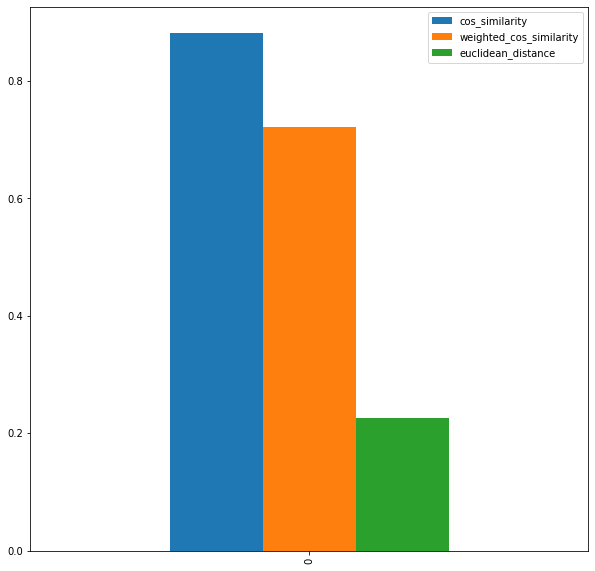

{'cos_similarity': [0.8821361068600927],
 'weighted_cos_similarity': [0.7216785834596041],
 'euclidean_distance': [0.2259686836983951]}

In [72]:
input_folder = "inputs"
pose_folder = os.path.join(input_folder, "pose_1")

file_names = get_filenames_in_folder(pose_folder)
images = []

for name in file_names:
    file_path = os.path.join(pose_folder, name)
    image = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)
    images.append(image)

pose_results = get_pose_estimations(images, plot_images=False)
aggregate_similarity_pose_metrics = compare_pose_estimation_similarities(pose_results, file_names)
# plot_metric_barh_chart(aggregate_similarity_pose_metrics)

get_metric_mean_differences(aggregate_similarity_pose_metrics, plot=True)

pose_comparison_average_scores {'cos_similarity': 0.429835890314854, 'weighted_cos_similarity': 0.3817261665331713, 'euclidean_distance': 0.6752672141447429}
pose_comparison_average_scores {'cos_similarity': 0.7812360865633113, 'weighted_cos_similarity': 0.5641036381097461, 'euclidean_distance': 0.4019556348323662}
pose_comparison_average_scores {'cos_similarity': 0.3662074387551458, 'weighted_cos_similarity': 0.33220672986743954, 'euclidean_distance': 0.6712705913093865}


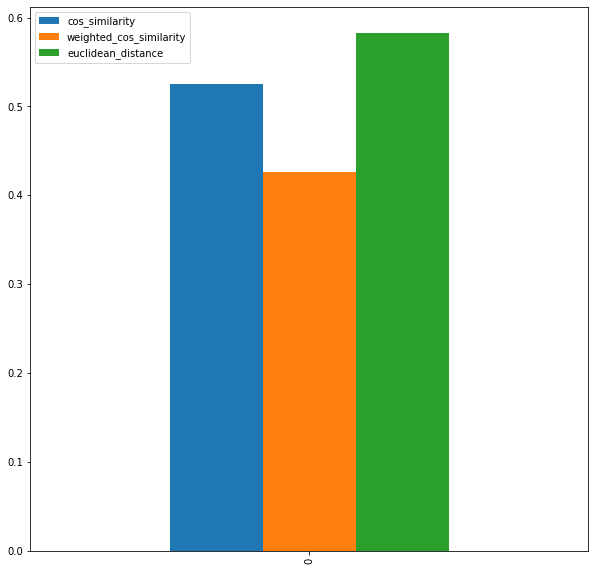

{'cos_similarity': [0.5257598052111037],
 'weighted_cos_similarity': [0.426012178170119],
 'euclidean_distance': [0.5828311467621652]}

In [70]:
input_folder = "inputs"

folders = ["pose_1", "pose_2", "warrior"]
images, file_names = [], []

for folder in folders:
    img_path = os.path.join(input_folder, folder, "1.jpg")
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    images.append(image)
    
    file_names.append(folder)
    

pose_results = get_pose_estimations(images, plot_images=False)
aggregate_similarity_pose_metrics = compare_pose_estimation_similarities(pose_results, file_names)
# plot_matrics_diff_chart(aggregate_similarity_pose_metrics)
# plot_metric_barh_chart(aggregate_similarity_pose_metrics)

get_metric_mean_differences(aggregate_similarity_pose_metrics, plot=True)

## Metric comparissons

Note: euclidean_cos_similarity has issues when computing 
Looking at the 4 metrics we see that 

Image: pose_1_vs_pose_2
metrics_dict: {'cos_similarity': 0.429835890314854, 'euclidean_cos_similarity': 0.9101111489671052, 'euclidean_distance': 0.6752672141447429, 'weighted_cos_similarity': 0.3817261665331713}
percentage_diffs [1.1173456416132457, 0.0, 0.3477792641240594, 1.384199011644171]
max_diff_metric: euclidean_cos_similarity
Image: pose_1_vs_warrior
metrics_dict: {'cos_similarity': 0.7812360865633113, 'euclidean_cos_similarity': 1.229967912906897, 'euclidean_distance': 0.4019556348323662, 'weighted_cos_similarity': 0.5641036381097461}
percentage_diffs [0.5743869670915674, 0.0, 2.0599593744216316, 1.180393512490709]
max_diff_metric: euclidean_cos_similarity
Image: pose_2_vs_warrior
metrics_dict: {'cos_similarity': 0.3662074387551458, 'euclidean_cos_similarity': 0.7436469910605217, 'euclidean_distance': 0.6712705913093865, 'weighted_cos_similarity': 0.33220672986743954}
percentage_diffs [1.0306714510999875, 0.0, 0.10782000684695144, 1.2385067014062574]
max_diff_metric: euclidea

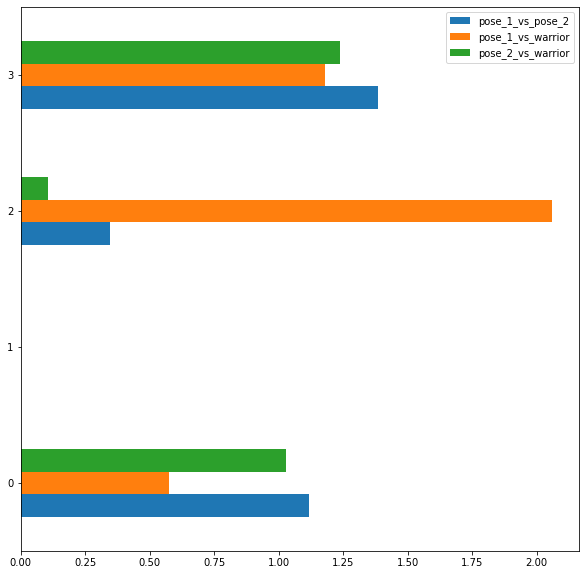

In [34]:
metrics_count = {}
diff_dict = {}

for key, metrics_dict in aggregate_similarity_pose_metrics.items():
    print(f"Image: {key}")
    print(f"metrics_dict: {metrics_dict}")
    
    metrics = list(metrics_dict.keys())
    values = list(metrics_dict.values())
    
    
    max_diff_pos = np.argmax(values)
    max_value = values[max_diff_pos]
    max_diff_metric = metrics[max_diff_pos]
    
    percentage_diffs = [(max_value - v)/v for v in values]
    print("percentage_diffs", percentage_diffs)

    print(f"max_diff_metric: {max_diff_metric}")
    
    diff_dict[key] = percentage_diffs


fig, ax = plt.subplots(figsize=(10, 10))

diff_df = pd.DataFrame(diff_dict)
diff_df.plot.barh(ax=ax)
plt.show()
    
#     if max_diff_metric in metrics_count:
#         metrics_count[max_diff_metric] = metrics_count[max_diff_metric] + 1
#     else:
#         metrics_count[max_diff_metric] = 1
        
# metrics_count

In [17]:
[for k, v in aggregate_similarity_pose_metrics.items()]

{'3.jpg_vs_1.jpg': {'cos_similarity': 0.8159247999981535,
  'euclidean_cos_similarity': 1.2527059680013346,
  'euclidean_distance': 0.315635377445429,
  'weighted_cos_similarity': 0.7259721989332956},
 '3.jpg_vs_2.jpg': {'cos_similarity': 0.9930932383788219,
  'euclidean_cos_similarity': 1.4093175074032902,
  'euclidean_distance': 0.08315571076206023,
  'weighted_cos_similarity': 0.895011580275933},
 '1.jpg_vs_2.jpg': {'cos_similarity': 0.8373902822033025,
  'euclidean_cos_similarity': 1.2667895351086718,
  'euclidean_distance': 0.279114962887696,
  'weighted_cos_similarity': 0.5440519711695838}}

In [27]:
for aggregate_similarity_pose_metrics

{'pose_1_vs_pose_2': {'cos_similarity': 0.429835890314854,
  'euclidean_cos_similarity': 0.9101111489671052,
  'euclidean_distance': 0.6752672141447429,
  'weighted_cos_similarity': 0.3817261665331713},
 'pose_1_vs_warrior': {'cos_similarity': 0.7812360865633113,
  'euclidean_cos_similarity': 1.229967912906897,
  'euclidean_distance': 0.4019556348323662,
  'weighted_cos_similarity': 0.5641036381097461},
 'pose_2_vs_warrior': {'cos_similarity': 0.3662074387551458,
  'euclidean_cos_similarity': 0.7436469910605217,
  'euclidean_distance': 0.6712705913093865,
  'weighted_cos_similarity': 0.33220672986743954}}

In [ ]:
# def plot_metric_barh_chart(aggregate_similarity_pose_metrics):
#     similarity_plotting_df = pd.DataFrame(aggregate_similarity_pose_metrics)

#     fig, ax = plt.subplots(figsize=(10, 10))
#     similarity_plotting_df.plot.barh(ax=ax)
#     plt.show()
    
def plot_matrics_diff_chart(aggregate_similarity_pose_metrics):
    similarity_plotting_df = pd.DataFrame(aggregate_similarity_pose_metrics)

    fig, ax = plt.subplots(figsize=(10, 10))
    similarity_plotting_df.plot.barh(ax=ax)
    plt.show()

file_names ['3.jpg', '2.JPG', '1.jpg']
pose_comparison_average_scores {'cos_similarity': 0.9414026468222284, 'euclidean_cos_similarity': 1.371941843568545, 'euclidean_distance': 0.2227383043313839, 'weighted_cos_similarity': 0.8848871422315527}
pose_comparison_average_scores {'cos_similarity': 0.9964906051859774, 'euclidean_cos_similarity': 1.4117275109332919, 'euclidean_distance': 0.055926233101240494, 'weighted_cos_similarity': 0.9381087677919318}
pose_comparison_average_scores {'cos_similarity': 0.935441587525661, 'euclidean_cos_similarity': 1.3675681992821516, 'euclidean_distance': 0.23464835460864136, 'weighted_cos_similarity': 0.8804077853486382}


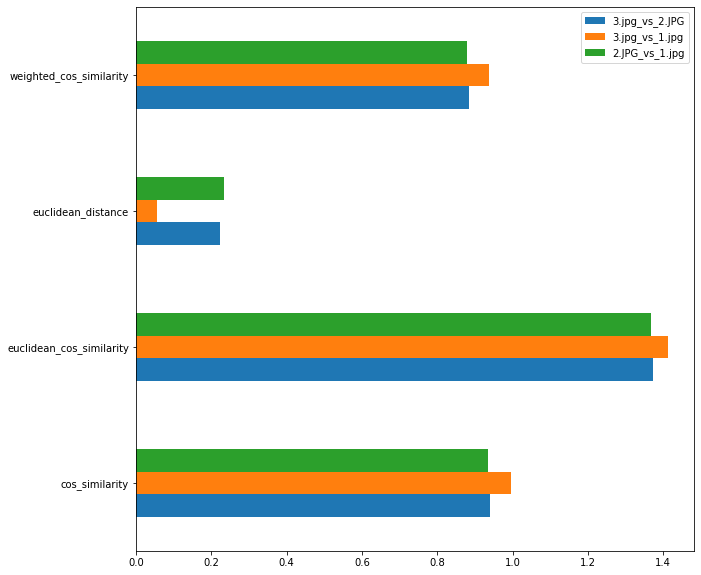

In [163]:
input_folder = "inputs"
pose_folder = os.path.join(input_folder, "pose_2")

file_names = get_filenames_in_folder(pose_folder)
images = []

for name in file_names:
    file_path = os.path.join(pose_folder, name)
    image = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)
    images.append(image)

print("file_names", file_names)

pose_results = get_pose_estimations(images, plot_images=False)
aggregate_similarity_pose_metrics = compare_pose_estimation_similarities(pose_results, file_names)
plot_metric_barh_chart(aggregate_similarity_pose_metrics)

file_names ['yoga_1.jpg', 'black.jpg', 'orange.jpg', '1.jpg']
pose_comparison_average_scores {'cos_similarity': 0.9521843681741669, 'euclidean_cos_similarity': 1.3797109529731315, 'euclidean_distance': 0.18326980069856083, 'weighted_cos_similarity': 0.9486655750257857}
pose_comparison_average_scores {'cos_similarity': 0.9986200778377998, 'euclidean_cos_similarity': 1.4132371764553426, 'euclidean_distance': 0.03617189080567917, 'weighted_cos_similarity': 0.9950212476495595}
pose_comparison_average_scores {'cos_similarity': 0.9921455035205315, 'euclidean_cos_similarity': 1.4086269119529757, 'euclidean_distance': 0.084500770928964, 'weighted_cos_similarity': 0.9885886473663793}
pose_comparison_average_scores {'cos_similarity': 0.9536362833880402, 'euclidean_cos_similarity': 1.3806972316110304, 'euclidean_distance': 0.1729363850119686, 'weighted_cos_similarity': 0.9485743744611581}
pose_comparison_average_scores {'cos_similarity': 0.9434653170962388, 'euclidean_cos_similarity': 1.373359634

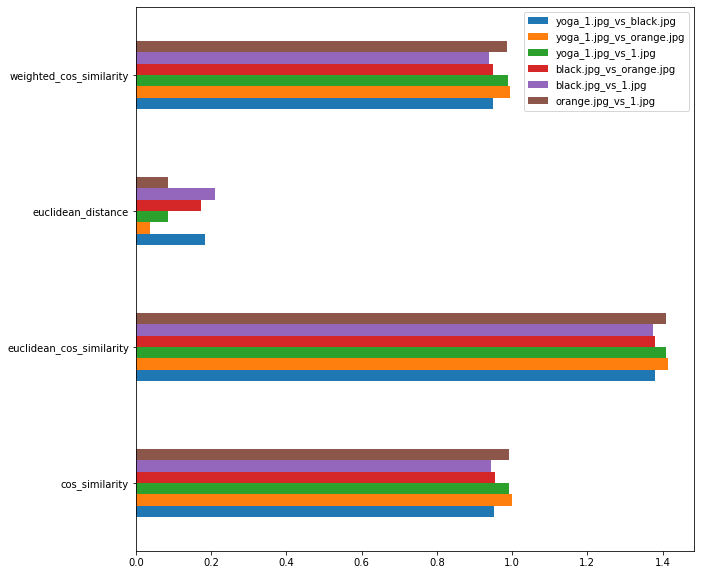

In [162]:
input_folder = "inputs"
pose_folder = os.path.join(input_folder, "warrior")

file_names = get_filenames_in_folder(pose_folder)
images = []

for name in file_names:
    file_path = os.path.join(pose_folder, name)
    image = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)
    images.append(image)

print("file_names", file_names)

pose_results = get_pose_estimations(images, plot_images=False)
aggregate_similarity_pose_metrics = compare_pose_estimation_similarities(pose_results, file_names)
plot_metric_barh_chart(aggregate_similarity_pose_metrics)

file_names ['3.jpg', '1.jpg', '2.jpg', '4.jpg']
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
pose_comparison_average_scores {'cos_similarity': -0.23195261828641578, 'euclidean_cos_similarity': 0.2522174110620621, 'euclidean_distance': 0.736931957092023, 'weighted_cos_similarity': -0.2030595743100975}
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosine sqrt issue
Cosin

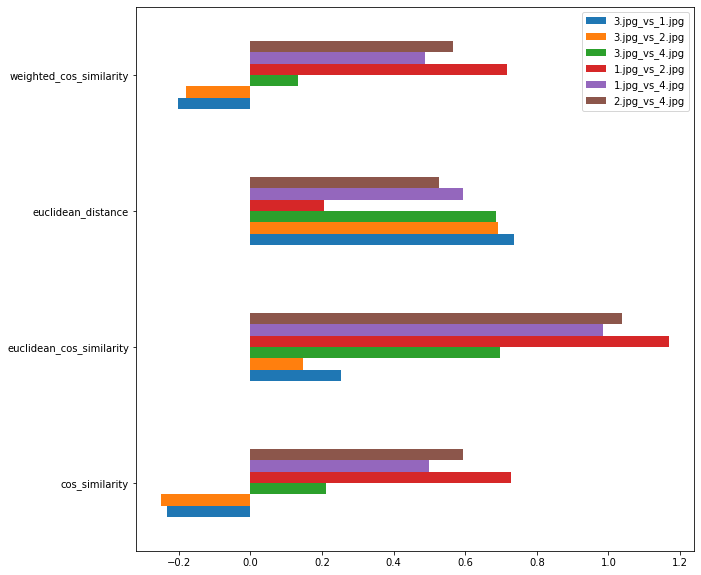

In [165]:
input_folder = "inputs"
pose_folder = os.path.join(input_folder, "non_similair_poses")

file_names = get_filenames_in_folder(pose_folder)
images = []

for name in file_names:
    file_path = os.path.join(pose_folder, name)
    image = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)
    images.append(image)

print("file_names", file_names)

pose_results = get_pose_estimations(images, plot_images=False)
aggregate_similarity_pose_metrics = compare_pose_estimation_similarities(pose_results, file_names)
plot_metric_barh_chart(aggregate_similarity_pose_metrics)

In [69]:
# pose_b

### Cosine similarity:
is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. The cosine of 0° is 1, and it is less than 1 for any angle in the interval (0,π] radians. It is thus a judgment of orientation and not magnitude: two vectors with the same orientation have a cosine similarity of 1, two vectors oriented at 90° relative to each other have a similarity of 0, and two vectors diametrically opposed have a similarity of -1, independent of their magnitude.


### Cosine similarity:


In [ ]:
# landmarks = [l.pose_world_landmarks.landmark for l in result_arr]

In [121]:
# cos_similarity_dict

In [42]:
# pose_a = pose_results[0].pose_world_landmarks.landmark
# pose_b = pose_results[1].pose_world_landmarks.landmark

# cos_similarity_dict = pose_cosine_similarity(pose_a, pose_b)
# # cos_similarity_dict

# pose_comparison_average_scores = {}
# for metric in ["cos_similarity", "euclidean_distance", "weighted_cos_similarity"]:  # Removed euclidean_cos_similarity
#     avg_scores = []
#     for pose_position in POSE_LANDMARKS:
#         score = cos_similarity_dict[pose_position][metric]
#         avg_scores.append(score)
        
#     pose_comparison_average_scores[metric] = np.mean(avg_scores)
    
# pose_comparison_average_scores

In [ ]:
def weighted_similarity_metric(pose_a, pose_b):
    model_a_points = [[f.x, f.y, f.z] for f in pose_a]
    model_b_points = [[f.x, f.y, f.z] for f in pose_b]

    kp_avg_dist = {}

    for kp_a, kp_b, kp_label in zip(model_a_points, model_b_points, POSE_LANDMARKS):
        # print("kp_a", kp_a)
        # print("kp_b", kp_b)
        dist = dtw.distance(kp_a, kp_b)
        # print(f"kp_label: {kp_label}. Dist = {dist:.3f}")
        kp_avg_dist[kp_label] = dist

    return kp_avg_dist

## TODO:
- Apply Pose Estimation to Videos


- Look into Pose comparrison (NEXT)
    - Get Time series data from a user performing an action (i.e. swining a golf club)
    - Compare to another action using a similarity function (cosine similarity) and Dynamic Time Warping (how similar are 2 actions)
    
    
https://medium.com/analytics-vidhya/human-pose-comparison-and-action-scoring-using-deep-learning-opencv-python-c2bdf0ddecba

# TODO:

- Get test videos of actions being done

In [ ]:
result_arr = []

# Run MediaPipe Pose and plot 3d pose world landmarks.
with mp_holistic.Holistic(
    static_image_mode=True, min_detection_confidence=0.75, model_complexity=2, 
) as pose:
    for img in images:


        results = pose.process(img)
        result_arr.append(results)
        # mp_drawing.plot_landmarks(results.pose_world_landmarks,  mp_pose.POSE_CONNECTIONS)
        # plt.xlabel('X')
        # plt.ylabel('Y')
        # plt.zlabel('Z')
        # plt.show()


# agg_dist_arr = []
# # All pairwise comparissons
# landmarks = [l.pose_world_landmarks.landmark for l in result_arr]
# for landmark_a, landmark_b in itertools.combinations(landmarks, 2):
#     kp_total_dist = compare_3d_poses(landmark_a, landmark_b)
#     agg_dist_arr.append(kp_total_dist)
#     print("kp_total_dist", kp_total_dist) 

# agg_dist = np.mean(agg_dist_arr)
# print(f"agg_dist: {agg_dist:.3f}")


points = []
for l in landmarks:
    model_points = [[f.x, f.y, f.z] for f in l]
    points.append(model_points)

points = np.array(points)
print(points.shape)
points


In [ ]:

from dtaidistance import dtw

timeseries = []
ds = dtw.distance_matrix_fast(points, parallel=True)
ds

In [ ]:
avg_ds = np.mean(ds, axis=-1)
avg_ds

In [ ]:
# Apply this to a video

# We need to create array of (x, y, z) points across frames for a given keypoint:


video_a_dict[Nose] = [(x1,y1,z1), (x2,y2,z2), ..., (xN,yN,zN)]
video_a_dict[ELBOW] = [(x1,y1,z1), (x2,y2,z2), ..., (x_N,y_N,z_N)]

Then we can use the distance comparrision across these arrays

In [ ]:
a = [1,2,1,1,1,3,4,1,1,1]
b = [1,2,1,3,4,1]

dtw.distance(a, b)